# Style transfer project


In this notebook, the style transfer method outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) will be recreated in PyTorch. In this paper, style transfer uses the features found in the 19-layer VGG Network.

Style transfer relies on separating the content and style of an image. Given one content image and one style image, the aim is to create a new image combining both:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

Part of the code was provided by Udacity, requiring the student to implement some sections. These sections are marked by "input start" and "input end".

---
## 0.- Import resources

In [1]:
# Import necessary libraries

%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

---
## 1.- Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`: convolutional and pooling layers
* `vgg19.classifier`: linear classifier layers

In this script, only the `features` portion will be needed, for which the weights will be frozen.

In [2]:
# Get "features" portion of VGG19

vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters

for param in vgg.parameters():
    param.requires_grad_(False)

# Check for a GPU

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')    

# Move the model to GPU if available

if train_on_gpu:
    vgg.cuda()

Training on GPU!


## 2.-  Load in content and style images

A helper function "load_image" is defined for loading images of any type and size, and converting them to normalized Tensors.

Next, images are loaded by file name and the style image is forced to be the same size as the content image. Then the images are displayed to check they have been correctly loaded and adjusted.

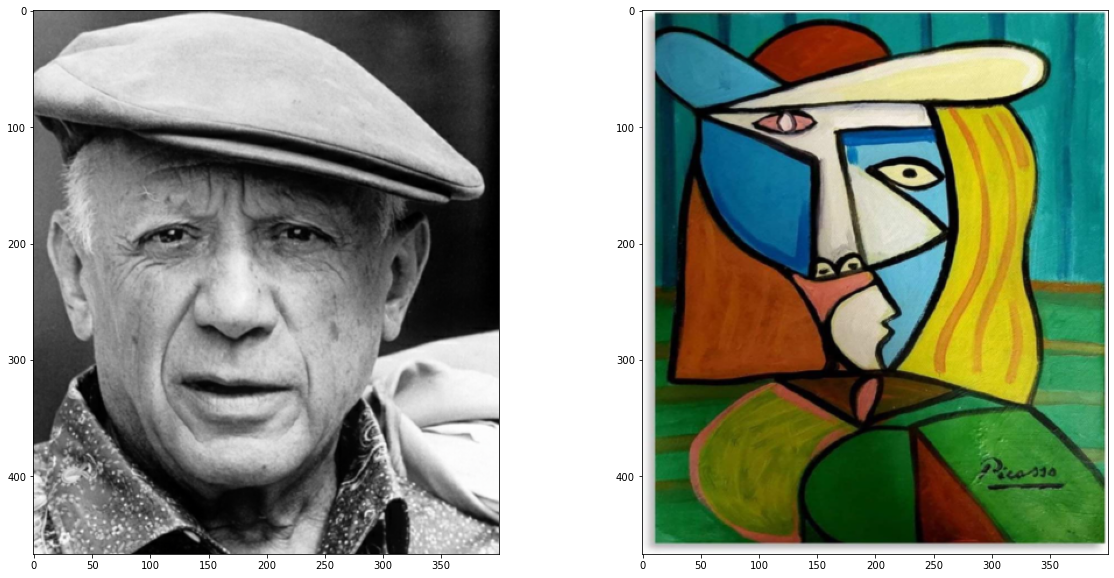

In [3]:
# Define load_image function

def load_image(img_path, max_size=400, shape=None):
    
    # Load image from website or local directory
    
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # Check that input image does not exceed max_size
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    # Check for prespecified shape
    
    if shape is not None:
        size = shape
    
    # Define transforms and transform image
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)
    
    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    
    image = image[:3,:,:].unsqueeze(0)
    
    return image

# load in content and style image and move to GPU if available

content = load_image('picasso_content.jpg')
if train_on_gpu:
    content = content.cuda()

# Resize style image to match content image and move to GPU if available

style = load_image('picasso_style.jpg', shape=content.shape[-2:])
if train_on_gpu:
    style = style.cuda()

# Define helper function for un-normalizing an image and converting it from Tensor to NumPy for display

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    if train_on_gpu:
        image = tensor.cpu()
    image = image.clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# Display the images

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## 3.- Obtain content and style features

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer. To do so, a set of layers were mapped following [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), for both the _content representation_ and the _style representation_.

In [4]:
# Define get_features function

def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    # INPUT START
    
    # Layers for the content and style representations of an image
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
        
    # INPUT END
    
    features = {}
    x = image
        
    for name, layer in model._modules.items(): # model._modules is a dictionary holding each module in the model
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## 4.- Define Gram matrix function 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

In [5]:
# INPUT START

# Define gram_matrix function

def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # Get the batch_size, depth, height, and width of the Tensor
    
    b, d, h, w = tensor.shape
    
    # Reshape it to multiply the features for each channel
    
    tensor = tensor.view(b * d, h * w)
    
    # Calculate the gram matrix
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

# INPUT END

---
## 5.- Feature extraction

The features from the style and content images are extraxted and gram matrices calculated for each layer in the style representation.

In [6]:
# Get content and style features

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate gram matrices for each layer

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create "target" image, prep it for change and move to GPU if avilable

target = content.clone().requires_grad_(True)
if train_on_gpu:
    target = target.cuda()

---
## 6.- Loss and weights

#### Individual layer style weights

Below the weights for each relevant layer of the style representation are set within a 0-1 range. Higher weights in earlier layers (`conv1_1` and `conv2_1`) are expected to get _larger_ style artifacts in the resulting target image. On the contrary, higher weights in later layers should result in higher emphasis on smaller features.

#### Content and style weight

Just like in the paper, an alpha (`content_weight`) and a beta (`style_weight`) are defined. This ratio will affect how _stylized_ the final image is. It's recommended to leave the content_weight = 1 and set the style_weight to achieve the desired ratio.

In [7]:
# INPUT START

# Weights for each style layer 

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# Content and style weights

content_weight = 1  # alpha
style_weight = 1e6  # beta

---
## 7.- Update the target and calculate losses

Inside the iteration loop, the content and style losses are calculated and the target image updated accordingly. The number of steps can be used to define the degree in which the target image is desired to change.

#### Content Loss

The content loss is the mean squared difference between the target and content features at layer `conv4_2`, and is calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

The style loss is calculated in a similar way, but iterating through a number of layers, specified by name in the dictionary `style_weights`. The gram matrix is calculated for the target image, `target_gram` and style image `style_gram` at each of these layers. Then the gram matrices are compared in order to calculate the `layer_style_loss`. This value is then normalized by the size of the layer.

#### Total Loss

Finally, the total loss is calculated by adding up the style and content losses and weighting them with the specified alpha and beta. This loss is printed when a number of iterarions defined in `show_every` have been performed.

Total loss:  55769080.0


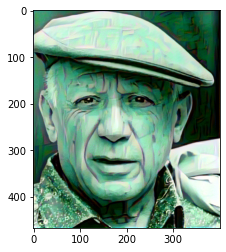

Total loss:  24553864.0


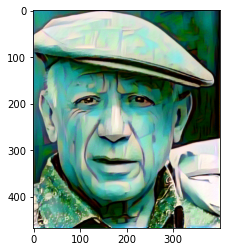

Total loss:  14187683.0


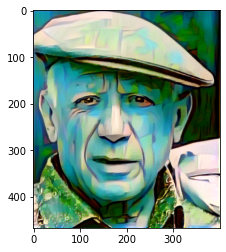

Total loss:  9325044.0


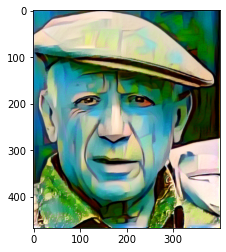

Total loss:  6497623.0


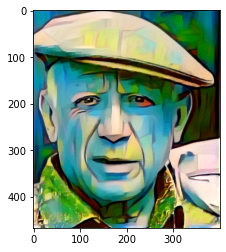

In [8]:
# Display target image after a number of iterations

show_every = 400

# Iteration hyperparameters

optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # iterations

# Iteration loop

for ii in range(1, steps+1):
    
    # INPUT START
    
    # Get the features from target image    
    
    target_features = get_features(target, vgg)
    
    # Calculate the content loss

    content_loss = torch.mean((content_features['conv4_2'] - target_features['conv4_2'])**2)
    
    # Initialize style loss to 0
    
    style_loss = 0
    
    # Iterate through each style layer and add to the style loss
    
    for layer in style_weights:
        
        # Get "target" style representation for the layer
        
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # Calculate the target gram matrixand get the "style" style representation
        
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        
        # Calculate the style loss for one layer, weighted appropriately and add to the style loss
        
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
        
    # Calculate total loss
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # INPUT END
    
    # Update target image
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Display intermediate images and print loss

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

---
## 8.- Display the Target Image

Below both the original content image and the target image are displayed.

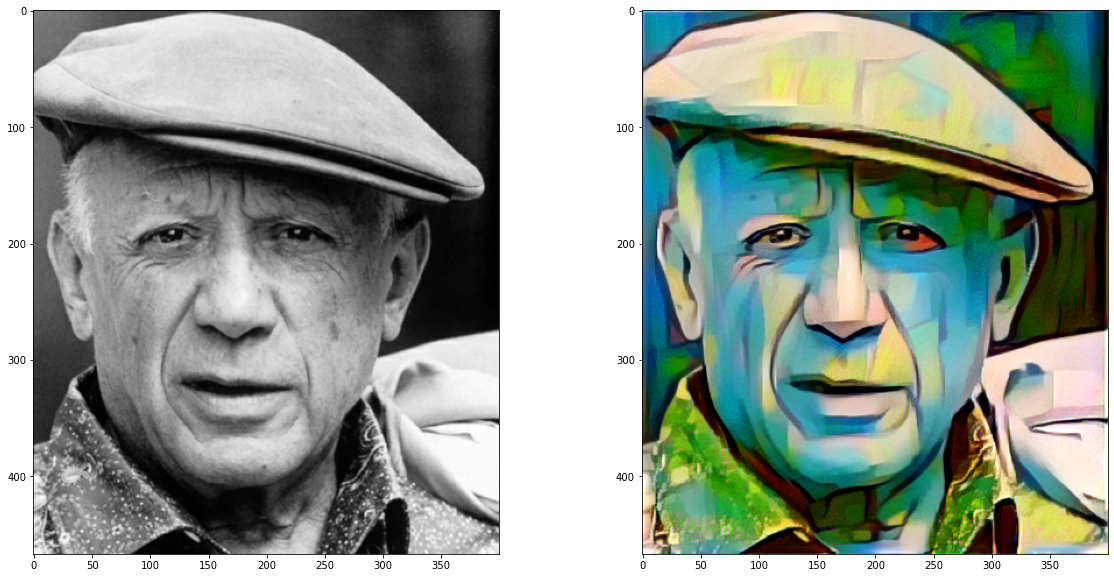

In [9]:
# Display content and final, target image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))